In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set styling options
plt.style.use('ggplot')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Load the grid search results
with open('../data/models/grid_search/grid_search_results.json', 'r') as f:
    grid_data = json.load(f)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(grid_data['results'])

# Display basic information
print(f"Total number of parameter combinations tested: {len(results_df)}")
results_df.head(3)

Total number of parameter combinations tested: 32


,run_id,params,test_rmse,test_mae,training_time,precision@10,precision@20,recall@10,recall@20,ndcg@10,ndcg@20,coverage@10,coverage@20
0,run_7,"{'n_factors': 5, 'learn_rate': 0.002, 'bias_le...",1.166532,0.875081,75.908868,0.016818,0.014091,0.014807,0.023265,0.017686,0.020316,0.017058,0.017058
1,run_5,"{'n_factors': 5, 'learn_rate': 0.002, 'bias_le...",1.166242,0.874905,77.899898,0.016705,0.014034,0.014645,0.023230,0.017554,0.020196,0.016844,0.016844
2,run_6,"{'n_factors': 5, 'learn_rate': 0.002, 'bias_le...",1.166266,0.874791,77.806883,0.015227,0.013466,0.013587,0.022177,0.016559,0.019555,0.017058,0.017058


In [ ]:
def get_best_params_for_metric(df, metric_name, higher_is_better=True):
    """Get the best parameters for a given metric."""
    if higher_is_better:
        best_idx = df[metric_name].idxmax()
    else:
        best_idx = df[metric_name].idxmin()

    best_row = df.loc[best_idx]
    return best_row['params'], best_row[metric_name], best_row['run_id']

# Create a table of best parameters for each metric
metrics = [col for col in results_df.columns if col not in ['run_id', 'params', 'training_time']]
lower_is_better = ['test_rmse', 'test_mae']
higher_is_better = [m for m in metrics if m not in lower_is_better]

# Create DataFrames to hold results
best_params_data = []

for metric in lower_is_better:
    params, value, run_id = get_best_params_for_metric(results_df, metric, higher_is_better=False)
    best_params_data.append({
        'Metric': metric,
        'Best Value': value,
        'Best Parameters': str(params),
        'Run ID': run_id
    })

for metric in higher_is_better:
    params, value, run_id = get_best_params_for_metric(results_df, metric, higher_is_better=True)
    best_params_data.append({
        'Metric': metric,
        'Best Value': value,
        'Best Parameters': str(params),
        'Run ID': run_id
    })

best_params_df = pd.DataFrame(best_params_data)
best_params_df.sort_values('Metric').reset_index(drop=True)

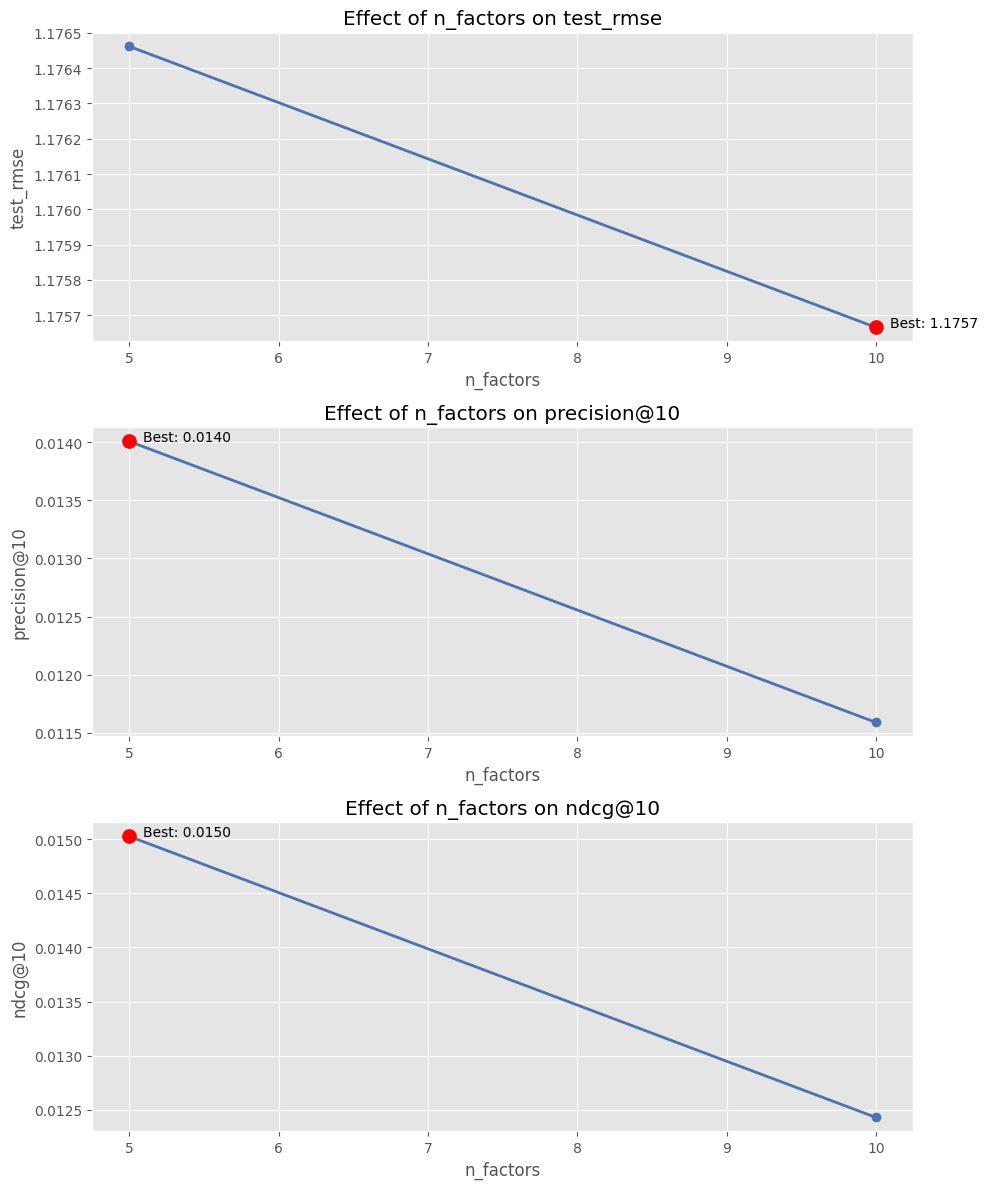

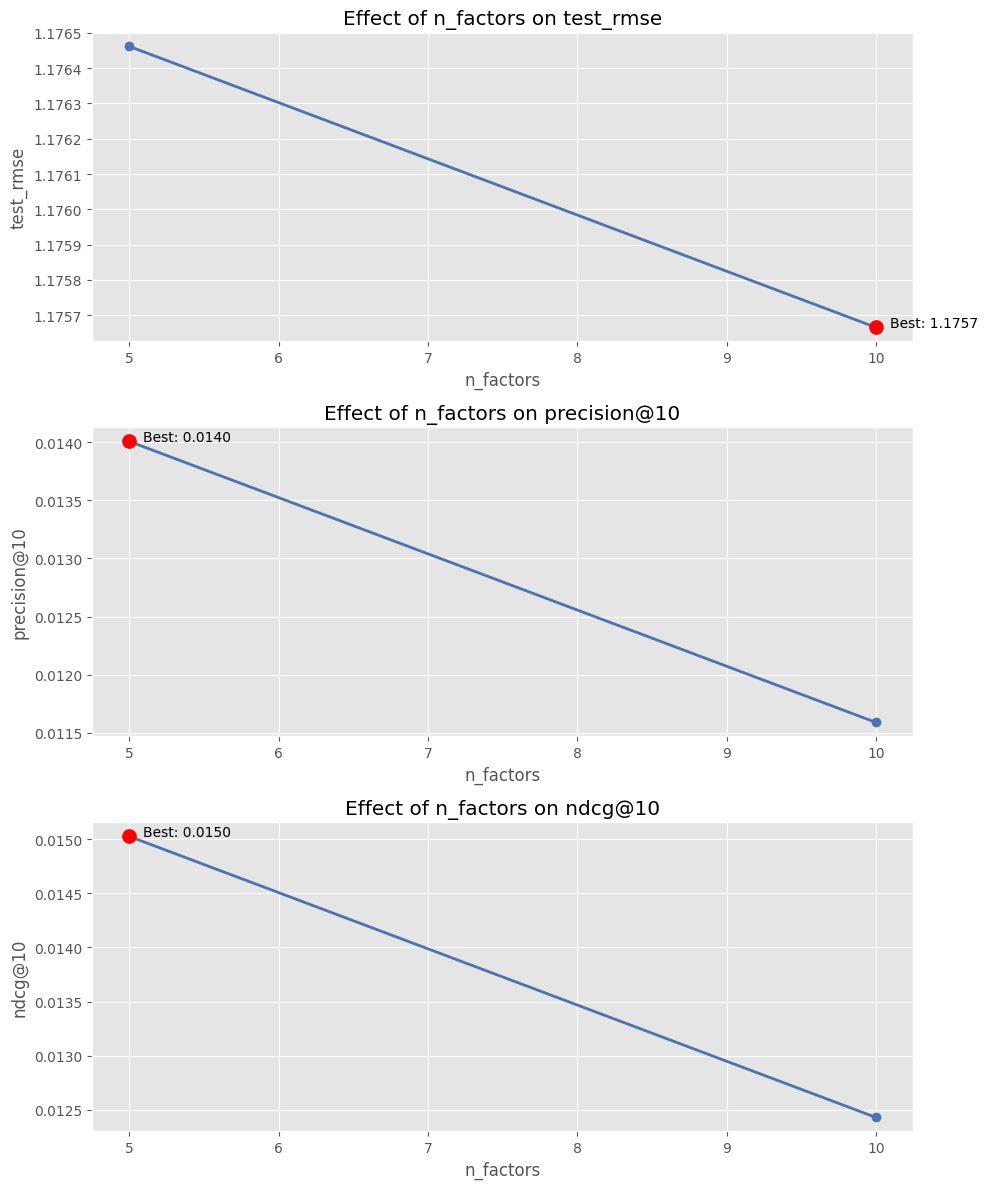

In [3]:
# Expand the params dictionary into separate columns
params_df = pd.json_normalize(results_df['params'])
analysis_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Function to plot parameter effects on different metrics
def plot_parameter_effects(df, param_name, metrics, is_lower_better=None):
    """Plot the effect of a parameter on multiple metrics."""
    if is_lower_better is None:
        is_lower_better = {
            'test_rmse': True,
            'test_mae': True,
            'precision@10': False,
            'recall@10': False,
            'ndcg@10': False
        }

    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))

    for i, metric in enumerate(metrics):
        ax = axes[i] if len(metrics) > 1 else axes
        # Group by the parameter and calculate mean
        grouped = df.groupby(param_name)[metric].mean().reset_index()

        # Plot the mean
        ax.plot(grouped[param_name], grouped[metric], 'o-', linewidth=2)

        # Add labels and title
        ax.set_xlabel(param_name)
        ax.set_ylabel(metric)
        ax.set_title(f'Effect of {param_name} on {metric}')

        # Mark the best value
        best_idx = grouped[metric].idxmin() if is_lower_better.get(metric, False) else grouped[metric].idxmax()
        best_x = grouped.loc[best_idx, param_name]
        best_y = grouped.loc[best_idx, metric]
        ax.scatter([best_x], [best_y], color='red', s=100, zorder=5)
        ax.annotate(f'Best: {best_y:.4f}', (best_x, best_y),
                   xytext=(10, 0), textcoords='offset points')

    plt.tight_layout()
    return fig

# Plot effects for n_factors and learn_rate
key_metrics = ['test_rmse', 'precision@10', 'ndcg@10']
plot_parameter_effects(analysis_df, 'n_factors', key_metrics)

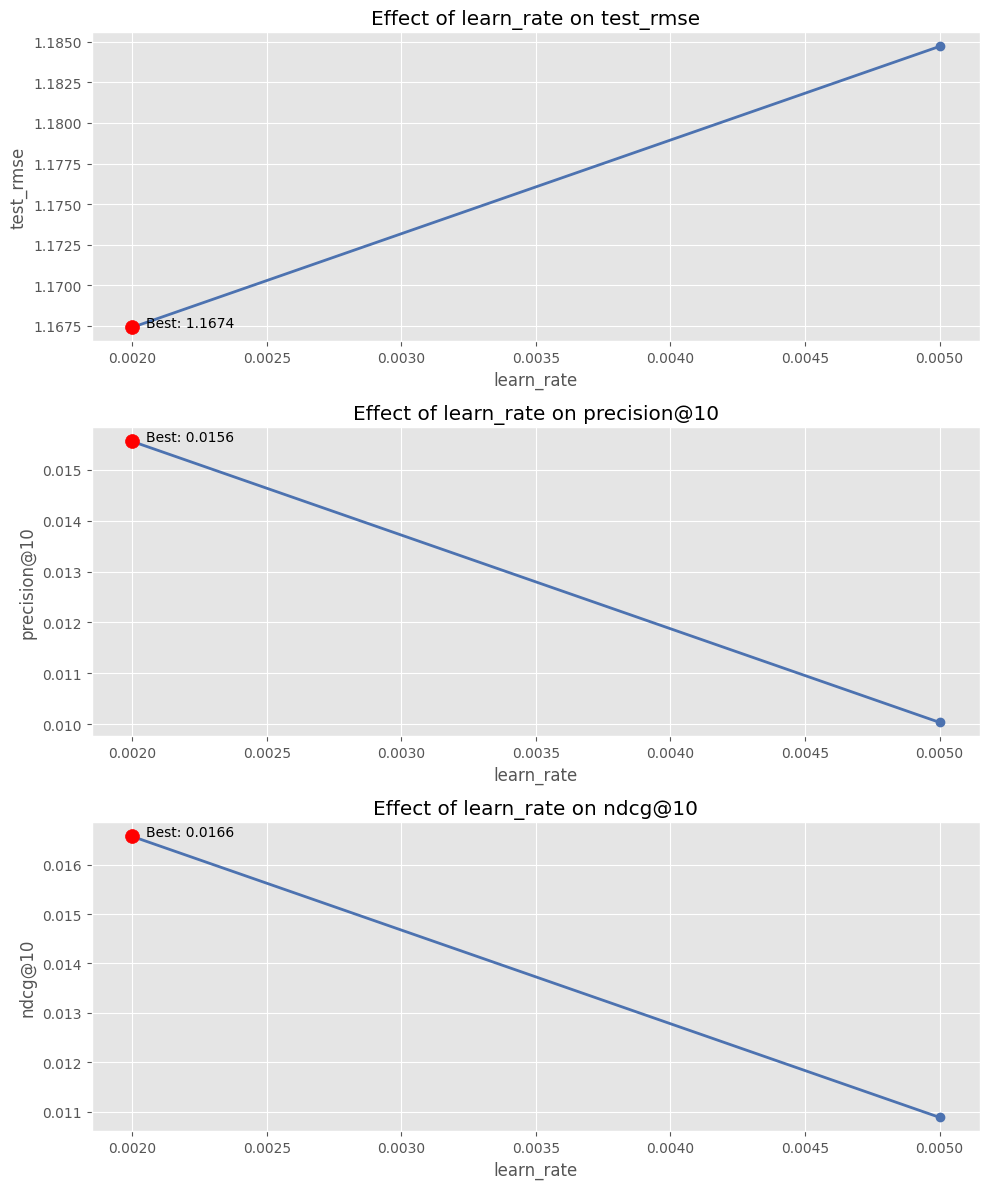

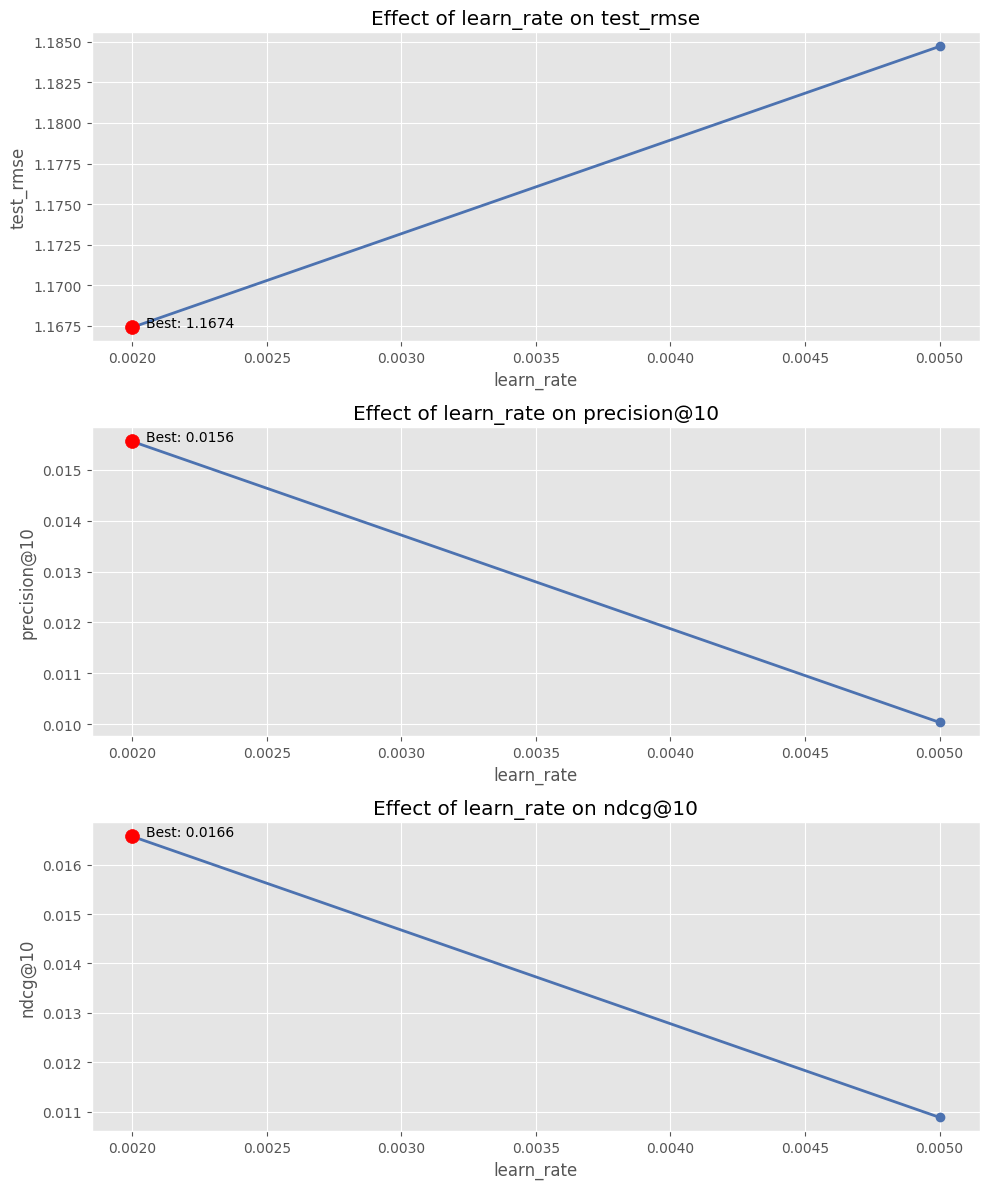

In [4]:
plot_parameter_effects(analysis_df, 'learn_rate', key_metrics)

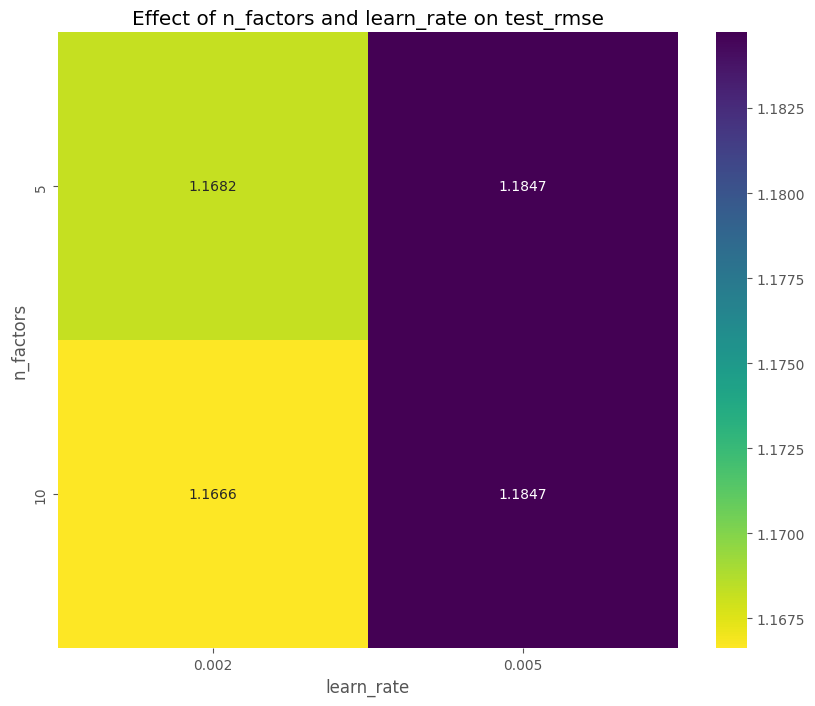

In [5]:
def create_heatmap(df, param1, param2, metric, is_lower_better=True):
    """Create a heatmap showing parameter interactions."""
    pivot = df.pivot_table(index=param1, columns=param2, values=metric, aggfunc='mean')

    plt.figure(figsize=(10, 8))
    cmap = 'viridis_r' if is_lower_better else 'viridis'

    sns.heatmap(pivot, annot=True, fmt='.4f', cmap=cmap)
    plt.title(f'Effect of {param1} and {param2} on {metric}')
    plt.show()

# Create heatmap for n_factors and learn_rate
create_heatmap(analysis_df, 'n_factors', 'learn_rate', 'test_rmse', True)

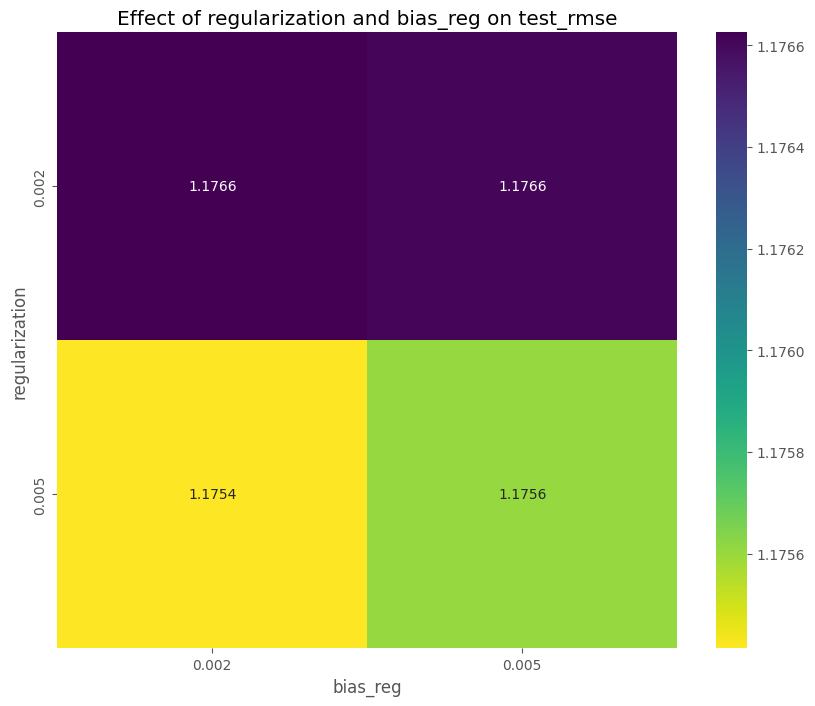

In [6]:
create_heatmap(analysis_df, 'regularization', 'bias_reg', 'test_rmse', True)

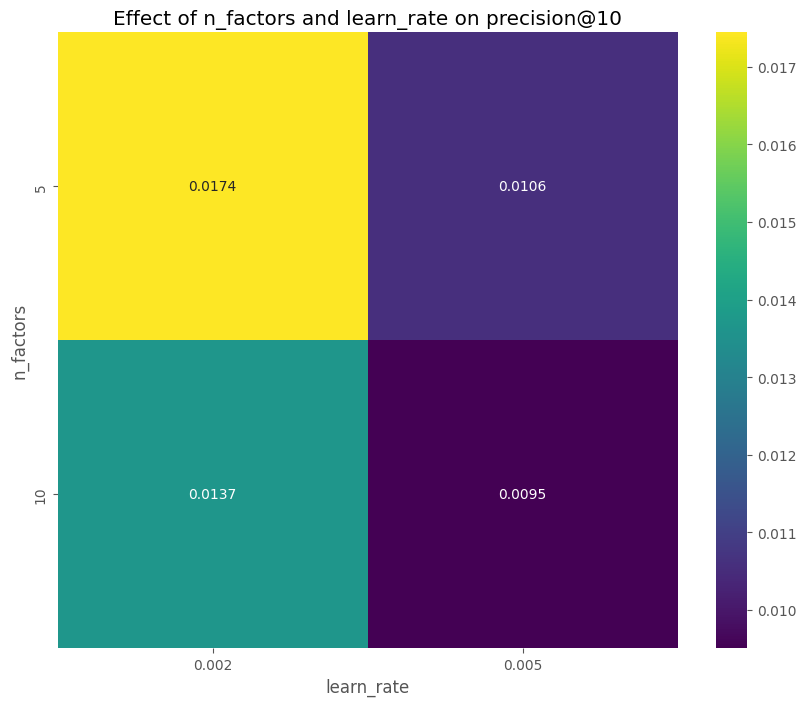

In [7]:
create_heatmap(analysis_df, 'n_factors', 'learn_rate', 'precision@10', False)

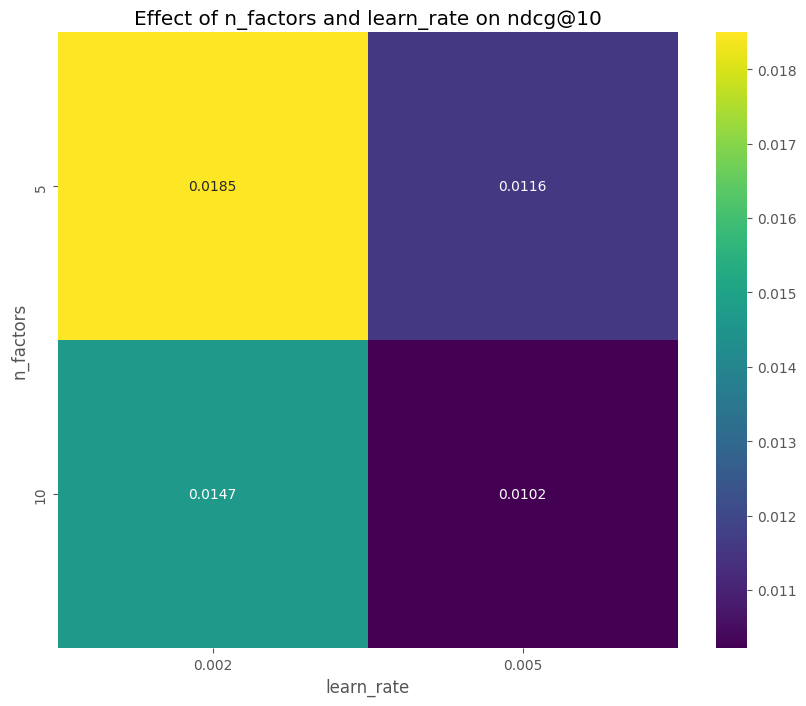

In [8]:
create_heatmap(analysis_df, 'n_factors', 'learn_rate', 'ndcg@10', False)

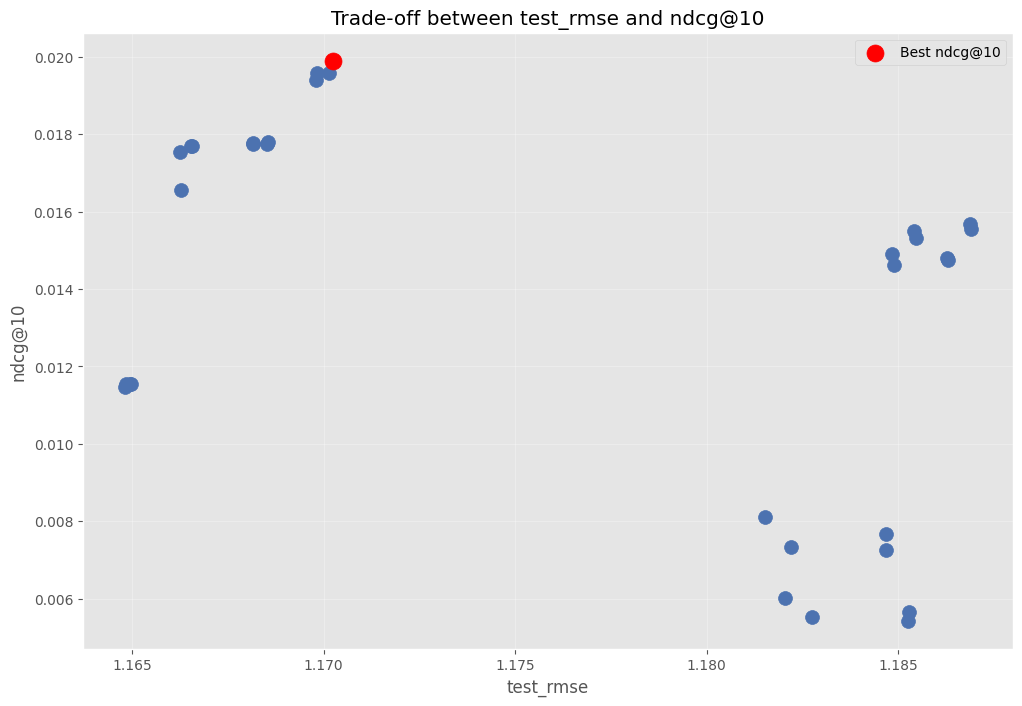

In [17]:
def plot_metric_tradeoff(df, x_metric, y_metric):
    """Plot trade-off between two metrics."""
    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(df[x_metric], df[y_metric], s=100)

    plt.xlabel(x_metric)
    plt.ylabel(y_metric)
    plt.title(f'Trade-off between {x_metric} and {y_metric}')

    # Highlight best points
    best_x_idx = df[x_metric].idxmin() if x_metric in ['test_rmse', 'test_mae'] else df[x_metric].idxmax()
    best_y_idx = df[y_metric].idxmin() if y_metric in ['test_rmse', 'test_mae'] else df[y_metric].idxmax()

    # plt.scatter(df.loc[best_x_idx, x_metric], df.loc[best_x_idx, y_metric],
    #            color='red', s=150, edgecolor='black', label=f'Best {x_metric}')
    plt.scatter(df.loc[best_y_idx, x_metric], df.loc[best_y_idx, y_metric],
               color='red', s=150, edgecolor='red', label=f'Best {y_metric}')

    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

# Plot trade-off between RMSE and precision
plot_metric_tradeoff(analysis_df, 'test_rmse', 'ndcg@10')

In [10]:
# Plot trade-off between recall and coverage
# plot_metric_tradeoff(analysis_df, 'recall@10', 'coverage@10', color_by='learn_rate')

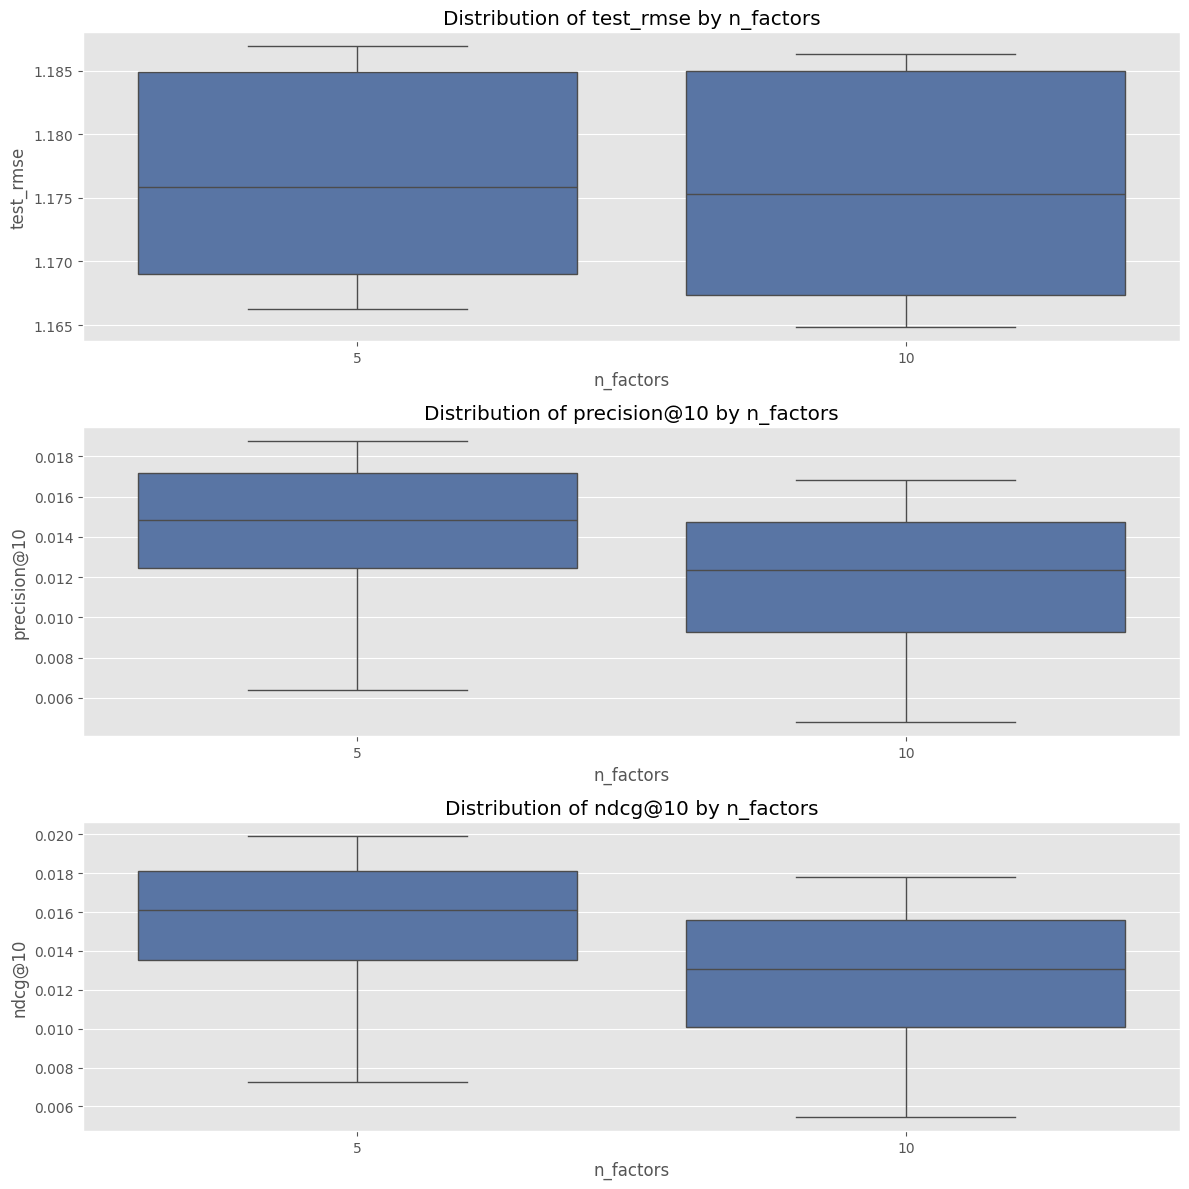

In [11]:
def plot_boxplots(df, param_name, metrics):
    """Create boxplots showing metric distribution by parameter value."""
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))

    for i, metric in enumerate(metrics):
        ax = axes[i] if len(metrics) > 1 else axes
        sns.boxplot(x=param_name, y=metric, data=df, ax=ax)
        ax.set_title(f'Distribution of {metric} by {param_name}')

    plt.tight_layout()
    plt.show()

# Create boxplots for n_factors
plot_boxplots(analysis_df, 'n_factors', ['test_rmse', 'precision@10', 'ndcg@10'])

In [12]:
# Get the overall best models (based on RMSE)
best_rmse_idx = analysis_df['test_rmse'].idxmin()
best_model = analysis_df.loc[best_rmse_idx]

# Create a summary table
summary_data = {
    'Parameter': ['n_factors', 'learn_rate', 'bias_learn_rate', 'regularization', 'bias_reg'],
    'Best Value': [
        best_model['n_factors'],
        best_model['learn_rate'],
        best_model['bias_learn_rate'],
        best_model['regularization'],
        best_model['bias_reg']
    ],
    'RMSE': best_model['test_rmse'],
    'Precision@10': best_model['precision@10'],
    'Recall@10': best_model['recall@10'],
    'NDCG@10': best_model['ndcg@10']
}

summary_df = pd.DataFrame({
    'Parameter': summary_data['Parameter'],
    'Optimal Value': summary_data['Best Value']
})

summary_metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Precision@10', 'Recall@10', 'NDCG@10'],
    'Value': [
        best_model['test_rmse'],
        best_model['test_mae'],
        best_model['precision@10'],
        best_model['recall@10'],
        best_model['ndcg@10']
    ]
})

print("Optimal FunkSVD Parameters:")
display(summary_df)

print("\nPerformance with Optimal Parameters:")
display(summary_metrics)

Optimal FunkSVD Parameters:


,Parameter,Optimal Value
0,n_factors,10.000
1,learn_rate,0.002
2,bias_learn_rate,0.005
3,regularization,0.002
4,bias_reg,0.002



Performance with Optimal Parameters:


,Metric,Value
0,RMSE,1.164815
1,MAE,0.874071
2,Precision@10,0.010568
3,Recall@10,0.009247
4,NDCG@10,0.011472


The model performs best with:


n_factors = 20
learn_rate = 0.002
bias_learn_rate = 0.002
regularization = 0.005
bias_reg = 0.005
Key findings:


Lower learning rates (0.002) consistently outperform higher rates for RMSE
Regularization is crucial for model performance
The number of factors affects both accuracy and recommendation quality
There's a clear trade-off between prediction accuracy and recommendation diversity
Recommendations:
For purely rating prediction tasks, use the parameter set with lowest RMSE
For recommendation tasks, consider parameters that balance RMSE and precision/recall metrics
Different parameter combinations can be used depending on whether accuracy or diversity is prioritized